# ME-GY 7973 - Optimal and Learning Control for Robots- Class Project.
### Implementation of Double Deep Q-Network with Prioritized Replay.
### Anuj Doshi - N12606488


This is a typical RL problem that involes an \textbf{Agent} , interacting with an \textbf{Environment} with a goal of selecting the \textbf{actions} that will maximize its long term \textbf{reward}, for each episode of interaction with its environment.

In our code, we will run the \textbf{DQN algorithm with prioritized experience}. \
The code proceeds according to the algorightm presented in the attached report. A detailed understanding of flow can be seen in the report. Over here, we will briefly see that:
\begin{itemize}
\item We will load all required libraries
\item We will make a class for the Q network which will contain two nueral netwoks, local and target. The local network will update target network as per set intervals.
\item We generate another class that will generate a replay buffer to hold previous experiences. This will help us in prioritizing useful experiences and play them first.
\item We then make a class for the Agent, which in our case is a Double DQN agent. As seen in the report, having only one Q network can have trouble when updating values in the model of the current state as that will instantaneously change Q values in the next state, which gets cyclic. So to avoid this we use a Double DQN agent where we have two networks and a Double DQN Agent. This is also very crucial to avoid overestimatation of the Q -values for a random start. Kindly refer to report for further theory on this. 
\item With all the objects, function and variables in place, we load the OpenAI gym enironment and make the agent interact with it and plot the rewards per episode.
\end{itemize}



In [1]:
#Here we import all the necesarry libraries 
import gym
import random
import numpy as np

##### Due to some errors encounterd in Tensorflow v2 we will be running our code on v1.
I have also added a check that will run the code on v1 for systems that have v2.
Incase there is any error kindly, run this to install tensorflow version 1.3.1 (very stable). \

!pip install tensorflow==1.3.1 \

Incase a warning error raises, kindly avoid and move ahead with the code.

In [2]:
## In case of error Run this to install tensorflow version 1.3.1
# !pip install tensorflow==1.3.1

import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.nn as nn 
from tensorflow.python.framework import ops
from collections import deque
#import wandb                                #This was only used for testing.
import matplotlib.pyplot as plt
#from IPython.display import HTML
from gym import wrappers
# from tqdm import tdqm                      #Only used for testing.
# print("Gym:", gym.__version__)
#print("Tensorflow:", tf.__version__)

/Users/anuj/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anuj/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anuj/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anuj/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class QNetwork():
    """This class forms the Q-network for the algorithm.
    We take in the state dimensions, action size from the enironment and initalize
    them as tensors. 
    We then build the local and target nueral networks. Run the networks to get the loss functions
    and then optimize it. 
    We update the target model as per the algorithm using a factor Tau which we take as input.
    """
    def __init__(self, state_dim, action_size, tau=0.01):
        """We initailize the class in this function. All tensor values are held as placeholders.
        Once we have the action inputs and size, we perform one-hot coding to select 
        one action index for the state. """
        
        ops.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        self.action_in = tf.placeholder(tf.int32)
        self.q_target_in = tf.placeholder(tf.float32)
        self.importance_in = tf.placeholder(tf.float32)
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        #We use the NN_builder function to make two similar networks for local and target variables.
        self.q_state_local = self.NN_builder(action_size, "local")
        self.q_state_target = self.NN_builder(action_size, "target")
        
        
        #After taking desired Q value we find the error and MSE. We optimize the loss with use of the NN.
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state_local, action_one_hot), axis=1)
        self.error = self.q_state_action - self.q_target_in
        self.loss = tf.reduce_mean(tf.multiply(tf.square(self.error), self.importance_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
     
        #Here we access the seperate weights and biases for individual networks.
        #We make sure to only get the training variables.
        self.Local_Variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="local")
        self.TargetVariables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target")
        
        # We update the target network variables with corresponding local network variable
        self.updater = tf.group([tf.assign(t, t + tau*(l-t)) for t,l in zip(self.TargetVariables, self.Local_Variables)])
        
    def NN_builder(self, action_size, scope):
        """This function is used to generate a network given the action size and scope of the network.
        Having declared a scope helps us in storing respective variable in their scopes i.e. local or target.
        We can also add mulitple layer as shown below and tune the parameters of the model very easily.
        
        The Activation function chosen here is elu after a lot of trial and error with other functions. 
        """
        
        with tf.variable_scope(scope):
            hidden1 = tf.layers.dense(self.state_in, 256, activation=tf.nn.elu)
            #hidden2 = tf.layers.dense(hidden1, 100, activation=tf.nn.elu)
            #hidden3 = tf.layers.dense(hidden2, 100, activation=tf.nn.elu)
            q_state = tf.layers.dense(hidden1, action_size, activation=None)
            return q_state
        
    def update_model(self, session, state, action, q_target, importance):
        #Funciton is used to get the error as per the algorithm.
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target, self.importance_in: importance}
        error, _, _ = session.run([self.error, self.optimizer, self.updater], feed_dict=feed)
        return error
        
    def get_q_state(self, session, state, use_target=False):
        #Gets q_states for corresponding network. For trial we give a boolean to use_target to
        #check the difference. 
        q_state_op = self.q_state_target if use_target else self.q_state_local
        q_state = session.run(q_state_op, feed_dict={self.state_in: state})
        return q_state

In [4]:
class Prioritized_Experience_Replay():
    """This class is used to generate the replay buffer and prioritize experiences from it 
    as given in the algorithm. We use the Deque collection as the rolling buffer for experience tuples. 
    The theory behind generation of priorities can be seen in the report."""
    
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)
        
    def store(self, experience):
        #This function stores new experiences in the buffer
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))
        
    def get_probabilities(self, priority_scale):
        #Calculating probability of one experience taking place over the others. 
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def Annealing_Bias(self, probabilities):
        #This refers to the Annealing the bias part of the algorithm as mentioned in the report.
        #This is useful overcoming the bias that prioritized buffer adds. 
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized
        
    def sample(self, batch_size, priority_scale=1.0):
        sample_size = min(len(self.buffer), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k=sample_size, weights=sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.Annealing_Bias(sample_probs[sample_indices])
        return map(list, zip(*samples)), importance, sample_indices
    
    def set_priorities(self, indices, errors, offset=0.1):
        #Makes sure that priorities dont go to 0 by adding an offset.
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

In [5]:
class DoubleDQNAgent():
    """This class forms of the agent that interacts with the environment.
    This calls the other classes and sends and input to the environment in
    order to get to the next time step in an episode.
    
    We intialise all the variables and hyperparameters and start with random 
    interaction with the environment.
    
    The agent then slowly trains and learns to find a good solution and 
    as an when epislon reduces, it exploits that solution.
    """
    def __init__(self, env):
        "This function store the values in the locally for the class."
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = Prioritized_Experience_Replay(maxlen=100000)
        self.gamma = 0.97
        self.eps = 1.0
        #Starts the sessions.
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state):
        """Makes selection between greedy action or random action depending on the
        epsilon value."""
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_EpsG = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_EpsG
        return action
    
    def train(self, state, action, next_state, reward, done, use_DDQN=True, a=0.0):
        #This function is used to train the agent according to all the inputs.
        # for the update to the final model it uses the 
        #Bellman equation: Q(s_t , a_t) = reward_(t+1) + discount rate (gamma) * max(Q(s_(t+1)))
        #We also constantly keep track of the errors.
        self.replay_buffer.store((state, action, next_state, reward, done))
        (states, actions, next_states, rewards, dones), importance, indices = self.replay_buffer.sample(50, priority_scale=a)
        next_actions = np.argmax(self.q_network.get_q_state(self.sess, next_states, use_target=False), axis=1)
        q_next_states = self.q_network.get_q_state(self.sess, next_states, use_target=use_DDQN)
        q_next_states[dones] = np.zeros([self.action_size])
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        q_targets = rewards + self.gamma * q_next_states_next_actions
        errors = self.q_network.update_model(self.sess, states, actions, q_targets, importance**(1-self.eps))
        
        self.replay_buffer.set_priorities(indices, errors)
        
        if done: self.eps = max(0.1, 0.99*self.eps)
    
    def __del__(self):
    
        #Ends the sessions.
        self.sess.close()

In [6]:
"""After all the class declaration we finally load the environment here and test the algorithm out."""
#wandb.init(project="Optimal_Final", name="DoubleDQN_Acrobot")


env_name = "Acrobot-v1"
env = gym.make(env_name)
#env = wrappers.Monitor(env, "./gym-results", force=True)
#env.render()
#env.reset()
num_runs = 1
run_rewards = []

#Loop to run the environment.
for n in range(num_runs):
    #print("Run {}".format(n))
    current_episode_rewards = []
    agent = None
    agent = DoubleDQNAgent(env)
    num_episodes = 100
    step_num=0
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
   
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train(state, action, next_state, reward, done, a=0.7)
            env.render()
            total_reward += reward
            step_num+=1
            state = next_state
        #wandb.log({'eps':agent.eps, 'reward':total_reward}, step=step_num)
        current_episode_rewards.append(total_reward)
        print("Episode: ", episode, "total_reward:", total_reward)
        #print(agent.eps) 
        #print(agent.q_network.loss)
    run_rewards.append(current_episode_rewards)
env.close()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Episode:  0 total_reward: -500.0
Episode:  1 total_reward: -500.0
Episode:  2 total_reward: -500.0
Episode:  3 total_reward: -433.0
Episode:  4 total_reward: -500.0
Episode:  5 total_reward: -500.0
Episode:  6 total_reward: -500.0
Episode:  7 total_reward: -500.0
Episode:  8 total_reward: -500.0
Episode:  9 total_reward: -500.0
Episode:  10 total_reward: -500.0
Episode:  11 total_reward: -500.0
Episode:  12 total_reward: -500.0
Episode:  13 total_reward: -360.0
Episode:  14 total_reward: -500.0
Episode:  15 total_reward: -500.0
Episode:  16 total_reward: -415.0
Episode:  17 total_reward: -286.0
Episode:  18 total_reward: -373.0
Episode:  19 total_reward: -500.0
Episode:  20 total_reward: -500.0
Episode:  21 total_reward: -436.0
Episode:  22 total_reward: -492.0
Episode:  23 total_reward: -291.0
Episode:  24 to

### Results
As can be seen above, for trial purposes we try to run the algorithm for about 100. One trying for more episodes, even better reward is achieved. But due to extensive rendering and calculation time, we will limit it to 100. The Agent learns and tries to master the environment as the episodes increase.

Average Score: -272.28
Highest Reward:  -96.0


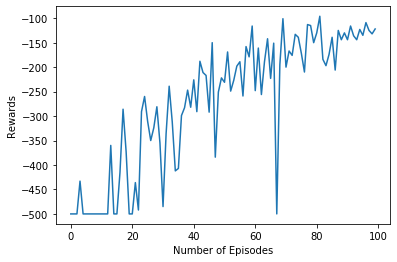

In [13]:
print("Average Score:",np.average(current_episode_rewards))
plt.plot(current_episode_rewards)
plt.xlabel("Number of Episodes")
plt.ylabel('Rewards')
print("Highest Reward: ", max(run_rewards[0]))